# Лабораторная работа №3

## Реализация сверточной нейронной сети

В работе предлагается использовать набор данных _notMNIST_, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (_A_ ... _J_, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.

Данные можно скачать по ссылке:

* https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz (большой набор данных);

* https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz (маленький набор данных);

Описание данных на английском языке доступно по ссылке:
http://yaroslavvb.blogspot.sg/2011/09/notmnist-dataset.html

### Задание 1

Реализуйте нейронную сеть с двумя сверточными слоями, и одним полносвязным с нейронами с кусочно-линейной функцией активации. Какова точность построенной модели?

Загрузим файл с датасетом, обработанным в лабораторной работе №1.

In [0]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:
BASE_DIR = '/content/drive/My Drive/Colab Files/mo-2'

import sys

sys.path.append(BASE_DIR)

import os

os.chdir(BASE_DIR)

In [0]:
import pandas as pd

dataframe = pd.read_pickle("./large.pkl")

In [0]:
! pip install tensorflow-gpu --pre --quiet

In [0]:
import tensorflow as tf

In [0]:
# To fix memory leak: https://github.com/tensorflow/tensorflow/issues/33009

tf.compat.v1.disable_eager_execution()

In [0]:
import numpy as np

In [0]:
dataframe_test = dataframe.sample(frac = 0.1)

dataframe = dataframe.drop(dataframe_test.index)

In [10]:
x = np.asarray(list(dataframe['data']))[..., np.newaxis]

x = tf.keras.utils.normalize(x, axis = 1)

x.shape

(415751, 28, 28, 1)

In [11]:
x_test = np.asarray(list(dataframe_test['data']))[..., np.newaxis]

x_test = tf.keras.utils.normalize(x_test, axis = 1)

x_test.shape

(46195, 28, 28, 1)

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

rcParams['figure.figsize'] = 8, 6

sns.set()
sns.set_palette(sns.color_palette('hls'))

def plot_accuracy(_history,
                  _train_acc_name = 'accuracy',
                  _val_acc_name = 'val_accuracy'):

    plt.plot(_history.history[_train_acc_name])
    plt.plot(_history.history[_val_acc_name])

    plt.title('Model accuracy')

    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.legend(['Train', 'Validation'], loc = 'right')

    plt.show()

def plot_loss(_history):

    plt.plot(_history.history['loss'])
    plt.plot(_history.history['val_loss'])

    plt.title('Model loss')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.legend(['Train', 'Validation'], loc = 'right')

    plt.show()

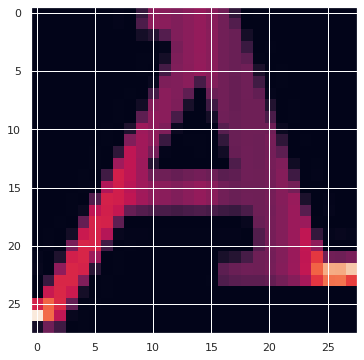

In [13]:
plt.imshow(x[0].squeeze())

plt.show()

In [0]:
IMAGE_DIM_0, IMAGE_DIM_1 = x.shape[1], x.shape[2]

In [15]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(dataframe['label']
                   .astype('category').cat.codes.astype('int32'))

y.shape

(415751, 10)

In [16]:
y_test = to_categorical(dataframe_test['label']
                        .astype('category').cat.codes.astype('int32'))

y_test.shape

(46195, 10)

In [0]:
CLASSES_N = y.shape[1]

In [0]:
DENSE_LAYER_WIDTH = 5000

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

model = tf.keras.Sequential()

model.add(Conv2D(16, 3, padding = 'same', activation = 'relu',
                 input_shape = (IMAGE_DIM_0, IMAGE_DIM_1, 1)))
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(DENSE_LAYER_WIDTH, activation = 'relu'))
model.add(Dense(CLASSES_N))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def cat_cross_from_logits(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(
        y_true, y_pred, from_logits = True)

model.compile(optimizer = 'sgd',
              loss = cat_cross_from_logits,
              metrics = ['categorical_accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 5000)              125445000 
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50010     
Total params: 125,499,810
Trainable params: 125,499,810
Non-trainable params: 0
_________________________________________________________________


In [0]:
VAL_SPLIT_RATE = 0.1

In [0]:
EPOCHS_N = 10

In [0]:
history = model.fit(x = x, y = y, epochs = EPOCHS_N,
                    validation_split = VAL_SPLIT_RATE, verbose = 0)

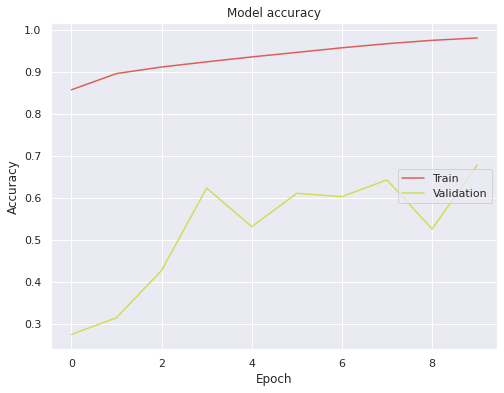

In [25]:
plot_accuracy(history, 'categorical_accuracy', 'val_categorical_accuracy')

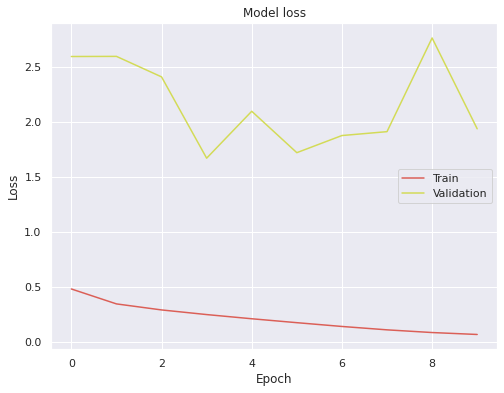

In [26]:
plot_loss(history)

In [27]:
results = model.evaluate(x_test, y_test)

print('Test loss, test accuracy:', results)

Test loss, test accuracy: [0.47965525410249255, 0.9042104]


Точность построенной модели на тестовой выборке составила 90%.

### Задание 2

Замените один из сверточных слоев на слой, реализующий операцию пулинга (_Pooling_) с функцией максимума или среднего. Как это повлияло на точность классификатора?

In [0]:
from tensorflow.keras.layers import MaxPooling2D

model_2 = tf.keras.Sequential()

model_2.add(Conv2D(16, 3, padding = 'same', activation = 'relu',
                   input_shape = (IMAGE_DIM_0, IMAGE_DIM_1, 1)))
model_2.add(MaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(DENSE_LAYER_WIDTH, activation = 'relu'))
model_2.add(Dense(CLASSES_N))

In [0]:
model_2.compile(optimizer = 'sgd',
               loss = cat_cross_from_logits,
               metrics = ['categorical_accuracy'])

In [30]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5000)              15685000  
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50010     
Total params: 15,735,170
Trainable params: 15,735,170
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_2 = model_2.fit(x = x, y = y, epochs = EPOCHS_N,
                        validation_split = VAL_SPLIT_RATE, verbose = 0)

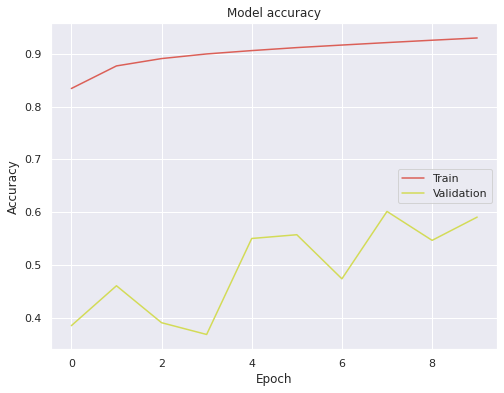

In [32]:
plot_accuracy(history_2, 'categorical_accuracy', 'val_categorical_accuracy')

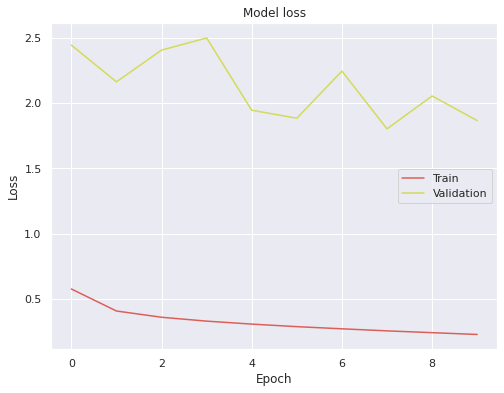

In [33]:
plot_loss(history_2)

In [34]:
results_2 = model_2.evaluate(x_test, y_test)

print('Test loss, test accuracy:', results_2)

Test loss, test accuracy: [0.44243563031696087, 0.88264966]


Замена свёрточного слоя на операцию пулинга немного снизила точность на тестовой выборке &mdash; до 88%.

### Задание 3

Реализуйте классическую архитектуру сверточных сетей _LeNet-5_ (http://yann.lecun.com/exdb/lenet/).

In [0]:
from tensorflow.keras.layers import AveragePooling2D

model_3 = tf.keras.Sequential()

model_3.add(Conv2D(6, kernel_size = (5, 5), strides = (1, 1),
                   activation = 'tanh', padding = 'same',
                   input_shape = (IMAGE_DIM_0, IMAGE_DIM_1, 1)))
model_3.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2),
                             padding = 'valid'))
model_3.add(Conv2D(16, kernel_size = (5, 5), strides = (1, 1),
                   activation = 'tanh', padding = 'valid'))
model_3.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2),
                             padding = 'valid'))
model_3.add(Flatten())
model_3.add(Dense(120, activation = 'tanh'))
model_3.add(Dense(84, activation = 'tanh'))
model_3.add(Dense(CLASSES_N, activation = 'softmax'))

In [0]:
model_3.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['categorical_accuracy'])

In [0]:
history_3 = model_3.fit(x = x, y = y, epochs = EPOCHS_N,
                        validation_split = VAL_SPLIT_RATE, verbose = 0)

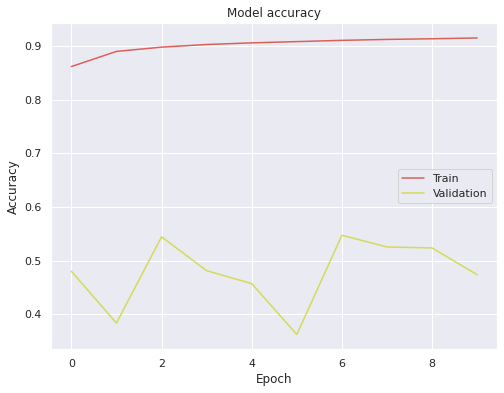

In [38]:
plot_accuracy(history_3, 'categorical_accuracy', 'val_categorical_accuracy')

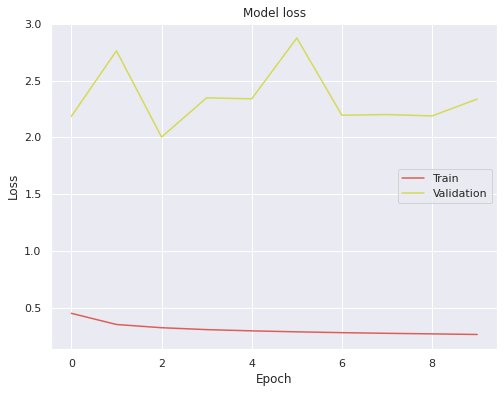

In [39]:
plot_loss(history_3)

In [40]:
results_3 = model_3.evaluate(x_test, y_test)

print('Test loss, test accuracy:', results_3)

Test loss, test accuracy: [0.49397167890073673, 0.8667388]


Удивительно, но _LeNet-5_ показала результат хуже, чем первая и вторая &mdash; 86% на тестовой выборке. Объяснить это можно различиями в размерностях слоёв.

### Задание 4

Сравните максимальные точности моделей, построенных в лабораторных работах 1-3. Как можно объяснить полученные различия?

Результаты на валидационной выборке:

* логистическая регрессия &mdash; 81%;

* модель с только полносвязными слоями &mdash; 10%;

    * с регуляризацией и сбросом нейронов &mdash; 63%;

        * с адаптивным шагом &mdash; 64%;

* модель с двумя свёрточными слоями и одним полносвязным &mdash; 90%;

* модель с одним свёрточным слоем, операцией пулинга и одним полносвязным &mdash; 88%;

* _LeNet-5_ &mdash; два свёрточных слоя, две операции пулинга, два полносвязных слоя &mdash; 86%.

Объяснение превосходства свёрточных сетей над полносвязными &mdash; такая архитектура лучше сочетается с природой изображений.